In [1]:
import tensorflow as tf
import numpy as np
import helpers

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [2]:
tf.__version__

'1.2.0'

In [3]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units * 2

In [4]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_length')
encoder_inputs_length = tf.placeholder(shape=(None, ), dtype=tf.int32, name='encoder_inputs_length')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

In [5]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1), dtype=tf.float32)

encoder_inputs_embeded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

In [6]:
from tensorflow.python.ops.rnn_cell import LSTMCell, LSTMStateTuple

In [7]:
encoder_cell = LSTMCell(encoder_hidden_units)

In [8]:
((encoder_fw_outputs, encoder_bw_outputs),
    (encoder_fw_final_state, encoder_bw_final_state)) = tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                                    cell_bw=encoder_cell,
                                                    inputs=encoder_inputs_embeded,
                                                    sequence_length=encoder_inputs_length,
                                                    dtype=tf.float32,
                                                    time_major=True)

In [9]:
#bidirectional step
#encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)
encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

In [10]:
#decoder
decoder_cell = LSTMCell(decoder_hidden_units)
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))
decoder_lengths = encoder_inputs_length + 3

In [11]:
#output projection
#define our weights and biases
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

In [12]:
W

<tf.Variable 'Variable_1:0' shape=(40, 10) dtype=float32_ref>

In [13]:
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

In [14]:
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)
    initial_input = eos_step_embedded
    initial_cell_state = encoder_final_state
    
    initial_cell_output = None
    initial_loop_state = None
    
    return (initial_elements_finished,
           initial_input,
           initial_cell_state,
           initial_cell_output,
           initial_loop_state)

In [15]:
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):
    
    def get_next_input():
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        prediction = tf.argmax(output_logits, axis=1)
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    elements_finished = (time >= decoder_lengths)
    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    
    state = previous_state
    output = previous_output
    loop_state = None
    
    return (elements_finished,
           input,
           state,
           output,
           loop_state)

In [16]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

#Creates an RNN specified by RNNCell cell and loop function loop_fn.
#This function is a more primitive version of dynamic_rnn that provides more direct access to the 
#inputs each iteration. It also provides more control over when to start and finish reading the sequence, 
#and what to emit for the output.
#ta = tensor array

In [17]:
decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [18]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)

decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

decoder_prediction = tf.argmax(decoder_logits, 2)

In [19]:
## Train

stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [20]:
sess.run(tf.global_variables_initializer())

In [21]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[9, 7, 6, 5, 3, 3, 7, 7]
[9, 4, 3]
[6, 4, 9, 2, 4]
[2, 2, 7, 6, 4]
[3, 6, 2, 8, 3, 2]
[2, 3, 2]
[8, 8, 3, 4]
[9, 2, 6, 6, 4, 7, 5]
[8, 3, 5, 5, 9]
[8, 6, 3, 3, 2]


In [35]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [36]:
loss_track = []
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 0.69416344165802
  sample 1:
    input     > [5 5 6 4 0 0 0 0]
    predicted > [5 5 6 4 1 0 0 0 0 0 0]
  sample 2:
    input     > [5 9 5 0 0 0 0 0]
    predicted > [5 5 5 1 0 0 0 0 0 0 0]
  sample 3:
    input     > [6 4 4 8 0 0 0 0]
    predicted > [4 4 8 8 1 0 0 0 0 0 0]

batch 1000
  minibatch loss: 0.30686402320861816
  sample 1:
    input     > [2 3 5 0 0 0 0 0]
    predicted > [2 3 5 1 0 0 0 0 0 0 0]
  sample 2:
    input     > [2 2 9 9 5 6 2 9]
    predicted > [2 2 9 9 5 9 9 2 1 0 0]
  sample 3:
    input     > [4 2 9 5 0 0 0 0]
    predicted > [4 2 9 5 1 0 0 0 0 0 0]

batch 2000
  minibatch loss: 0.18276268243789673
  sample 1:
    input     > [9 2 3 0 0 0 0 0]
    predicted > [9 2 3 1 0 0 0 0 0 0 0]
  sample 2:
    input     > [5 7 7 9 6 4 8 0]
    predicted > [5 7 7 9 6 4 8 1 0 0 0]
  sample 3:
    input     > [4 3 5 2 5 7 4 0]
    predicted > [4 3 5 2 7 7 4 1 0 0 0]

batch 3000
  minibatch loss: 0.11182677745819092
  sample 1:
    input     > [6 8 

loss 0.1242 after 300100 examples (batch_size=100)


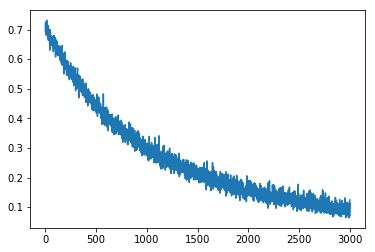

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

<tf.Tensor 'EOS:0' shape=(?,) dtype=int32>